In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import time
from scipy.spatial import KDTree
from collections import defaultdict
import gdsfactory as gf
import uuid
import sys


class Edge:
    def __init__(self, point1, point2, polygon_id=0):
        self.point1 = point1
        self.point2 = point2
        self.polygon_id = polygon_id
        self.midpoint = tuple((np.array(point1) + np.array(point2)) / 2)
    
    def __eq__(self, other):
        """Check if two edges are the same, accounting for order."""
        return (
            (np.allclose(self.point1, other.point1) and np.allclose(self.point2, other.point2)) or
            (np.allclose(self.point1, other.point2) and np.allclose(self.point2, other.point1))
        )

    def __hash__(self):
        """Hash for using Edge in sets or dictionaries."""
        return hash((tuple(sorted((tuple(self.point1), tuple(self.point2))))))

class Polygon:
    
    def __init__(self, edges_or_vertices, neighbors=None):
        if isinstance(edges_or_vertices, list) and all(isinstance(e, Edge) for e in edges_or_vertices):
            # Initialize from a list of Edge objects
            self.edges = edges_or_vertices
        elif isinstance(edges_or_vertices, np.ndarray):
            # Initialize from a numpy array of vertices
            self.edges = []
            num_points = edges_or_vertices.shape[0]
            for i, point in enumerate(edges_or_vertices):
                point1 = tuple(edges_or_vertices[i])
                point2 = tuple(edges_or_vertices[(i + 1) % num_points])
                edge = Edge(point1, point2)
                self.edges.append(edge)
        
        self.neighbors = neighbors if neighbors is not None else []
        self.merged = False
        self.visited = False
        pass
           
    def __eq__(self, other):
        """Check if two edges are the same, accounting for order."""
        return (
            set(self.edges) == set(other.edges)
        )
    
    def __hash__(self):
        h = 0
        for e in self.edges:
            h += hash(e)
        return h

    def merge(self, polygon):
        shared_edges = list(set(self.edges) & set(polygon.edges))
        combined_edges = list(set(self.edges + polygon.edges) - set(shared_edges))
        combined_neighbors = list(set(self.neighbors + polygon.neighbors) - set([self, polygon]))
        # edges = self.edges.copy()
        # edges.extend(polygon.edges)
        # edges = list(set(edges))        
        # neighbors = self.neighbors.copy()
        # neighbors.extend(polygon.neighbors)
        # neighbors = list(set(neighbors))
        for n in combined_neighbors[:]:
            if n.merged:
                combined_neighbors.remove(n)
        merged_polygon = Polygon(combined_edges, combined_neighbors)
        # neighbors = []
        # for n in merged_polygon.neighbors:
        #     if n != self and n != polygon:
        #         neighbors.append(n)
        # merged_polygon.neighbors = neighbors

        self.merged = True
        polygon.merged = True
        return merged_polygon
    
    def copy(self):
        edges = self.edges.copy()                
        neighbors = self.neighbors.copy()
                       
        return Polygon(edges, neighbors)

    def get_vertices(self):
        vertices = []
        for edge in self.edges:
            vertices.append(edge.point1)
            vertices.append(edge.point2)
        vertices = list(set(vertices))
        vertices = np.array(vertices)
        for i, v in enumerate(vertices):
            vertices[i, :] = v
            # Calculate the centroid of the points
            centroid = np.mean(vertices, axis=0)
            angles = np.arctan2(vertices[:, 1] - centroid[1], vertices[:, 0] - centroid[0])
            sorted_indices = np.argsort(angles)
            sorted_vertices = vertices[sorted_indices]
            # Step 4: Close the polygon by appending the first point to the end
            sorted_vertices = np.vstack([sorted_vertices, sorted_vertices[0]])
        return sorted_vertices

def polygon_neighbor_collect(polygon, connected_polygon_list):
    if not polygon.visited:
        polygon.visited = True
        connected_polygon_list.append(polygon)
        for n in polygon.neighbors:
            polygon_neighbor_collect(n, connected_polygon_list)
        return
    return
    
def get_polygon_family(polygon_list):
    polygon_family_list = []
    total_polygons = len(polygon_list)
    # Step 1: Collect neighbors into families
    for idx, p in enumerate(polygon_list):
        if not p.visited:
            connected_polygon_list = []
            polygon_neighbor_collect(p, connected_polygon_list)
            if len(connected_polygon_list) > 0:
                polygon_family_list.append(connected_polygon_list)
            else:
                polygon_family_list.append([p])
        
        # Print status update for collecting neighbors
        if idx % 1000 == 0:
            sys.stdout.write(f'\rCollecting polygon families: {idx + 1}/{total_polygons} completed')
            sys.stdout.flush()
        # time.sleep(0.01)  # This sleep is optional, just for demonstration purposes
        
    print(f"\nFinished collecting polygon families. Total polygon families found: {len(polygon_family_list)}")
    return polygon_family_list
    

def combine_polygons(polygon_family_list):
    combined_polygon_list = []
    total_families = len(polygon_family_list)    
    # Step 2: Combine the polygons in each family
    for idx, f in enumerate(polygon_family_list):
        if len(f) == 0:
            continue        
        # p_combined = f.pop(0)
        if len(f) == 1:
            combined_polygon_list.append(f[0])
            continue
        edges = []
        for p in f:
            edges.extend(p.edges)
        edges = list(set(edges))
        p_combined = Polygon(edges)
            # Merge each polygon in the family
            # p_combined = p_combined.merge(p)
        combined_polygon_list.append(p_combined)        
        # Print status update for combining families
        if idx % 1000 == 0:
            sys.stdout.write(f'\rCombining polygon families: {idx + 1}/{total_families} completed')
            sys.stdout.flush()        

    print("\nFinished combining all polygon families.")
    
    return combined_polygon_list


def plot_generated_polygons(polygons):
    """Plot the generated polygons."""
    plt.figure(figsize=(8, 6))
    color_map = plt.colormaps['tab10']  # Using 'tab10' colormap to have different colors for each polygon

    for idx, p in enumerate(polygons):
        color = color_map(idx % 10)  # Get a color from the colormap
        for edge_idx, e in enumerate(p.edges):
            edge_vertices = np.vstack([e.point1, e.point2])
            # Only add the label for the first edge of each polygon to avoid duplicate labels
            if edge_idx == 0:
                plt.plot(
                    edge_vertices[:, 0],
                    edge_vertices[:, 1],
                    marker='o',
                    color=color,
                    label=f'Polygon {idx}'
                )
            else:
                plt.plot(
                    edge_vertices[:, 0],
                    edge_vertices[:, 1],
                    marker='o',
                    color=color
                )

    plt.legend()
    plt.title("Generated Test Polygons")
    plt.axis('equal')
    plt.show()


def plot_generated_polygons_vertices(polygons_vertices):
    """Plot the generated polygons."""
    plt.figure(figsize=(8, 6))
    for idx, polygon in enumerate(polygons_vertices):
        plt.plot(
            np.append(polygon[:, 0], polygon[0, 0]),
            np.append(polygon[:, 1], polygon[0, 1]),
            marker='o',
            label=f'Polygon {idx}'
        )
    plt.legend()
    plt.title("Generated Test Polygons")
    plt.axis('equal')
    plt.show()

def extract_edges_from_polygons(polygons):
    start_time = time.time()
    edges = []
    all_points = []
    edge_map = defaultdict(list)  # Map from edges to their polygon IDs
    polygon_list = []
    # Step 1: Extract edges directly from ordered points
    print("Starting edge extraction from polygons...")
    for poly_id, points in enumerate(polygons):
        if (poly_id + 1) % 1000 == 0 or poly_id == len(polygons) - 1:
            print(f"\rExtracting edges from polygon {poly_id + 1}/{len(polygons)}...", end="", flush=True)
        num_points = len(points)
        polygon_edges = []
        for i in range(num_points):
            point1 = tuple(points[i])
            point2 = tuple(points[(i + 1) % num_points])
            edge = Edge(point1, point2, poly_id)
            edges.append(edge)
            polygon_edges.append(edge)
            all_points.append(edge.midpoint)
            edge_map[edge].append(poly_id)
        polygon_list.append(Polygon(polygon_edges))
    print(f"\nEdge extraction completed. Total edges extracted: {len(edges)}")
    print(f"Time taken for edge extraction: {time.time() - start_time:.2f} seconds")

    return edges, all_points, edge_map, polygon_list

def connect_polygons(edges, all_points, polygon_list):
    start_time = time.time()
    # Step 2: Build KD-Tree with edge midpoints
    print("Building KD-Tree with edge midpoints...")
    midpoints = np.array(all_points)
    kd_tree = KDTree(midpoints)
    print("KD-Tree built successfully.")
    # Step 3: Detect shared edges and merge polygons
    print("Detecting shared edges and merging polygons...")
    visited = set()  # To avoid processing the same edge twice    
    connected_polygons = 0
    for edge in edges:
        if edge in visited:
            continue
        # Query KD-Tree for the nearest edge
        dist, idx = kd_tree.query(edge.midpoint)
        nearest_edge = edges[idx]
        # Check if they are the same edge
        if edge != nearest_edge or edge.polygon_id == nearest_edge.polygon_id:
            continue
        polygon_list[edge.polygon_id].neighbors.append(polygon_list[nearest_edge.polygon_id])
        polygon_list[nearest_edge.polygon_id].neighbors.append(polygon_list[edge.polygon_id])
        connected_polygons += 1
        # Mark both edges as visited
        visited.add(edge)
        visited.add(nearest_edge)
    print(f"Polygon connection discovery completed. Total connected polygons found: {connected_polygons}")
    print(f"Time taken for polygon combination: {time.time() - start_time:.2f} seconds")
    return polygon_list


def plot_generated_polygons(polygons):
    """Plot the generated polygons."""
    plt.figure(figsize=(8, 6))
    color_map = plt.colormaps['tab10']  # Using 'tab10' colormap to have different colors for each polygon

    for idx, p in enumerate(polygons):
        color = color_map(idx % 10)  # Get a color from the colormap
        for edge_idx, e in enumerate(p.edges):
            edge_vertices = np.vstack([e.point1, e.point2])
            # Only add the label for the first edge of each polygon to avoid duplicate labels
            if edge_idx == 0:
                plt.plot(
                    edge_vertices[:, 0],
                    edge_vertices[:, 1],
                    marker='o',
                    color=color,
                    label=f'Polygon {idx}'
                )
            else:
                plt.plot(
                    edge_vertices[:, 0],
                    edge_vertices[:, 1],
                    marker='o',
                    color=color
                )

    plt.legend()
    plt.title("Generated Test Polygons")
    plt.axis('equal')
    plt.show()


def plot_generated_polygons_vertices(polygons_vertices):
    """Plot the generated polygons."""
    plt.figure(figsize=(8, 6))
    for idx, polygon in enumerate(polygons_vertices):
        plt.plot(
            np.append(polygon[:, 0], polygon[0, 0]),
            np.append(polygon[:, 1], polygon[0, 1]),
            marker='o',
            label=f'Polygon {idx}'
        )
    plt.legend()
    plt.title("Generated Test Polygons")
    plt.axis('equal')
    plt.show()


def create_gds_from_polygons(polygons, gds_filename="combined_polygons.gds"):
    """Create a GDS file from combined polygons using gdsfactory."""
    # Create a blank component with a unique name to avoid duplication
    component = gf.Component(f"combined_polygons_{uuid.uuid4().hex}")

    # Add each polygon to the component
    for idx, polygon in enumerate(polygons):
        # Create a GDS-compatible polygon by converting numpy array to list of tuples
        polygon_points = [tuple(map(float, point)) for point in polygon]
        # Add the polygon to the component
        component.add_polygon(polygon_points, layer=(1, 0))  # Layer 1, datatype 0

    # Write the component to a GDS file
    component.write_gds(gds_filename)
    print(f"GDS file '{gds_filename}' created successfully with {len(polygons)} polygons.")

def visit_neighbors(polygon):
    if not polygon.visited:
        polygon.visited = True
        for n in polygon.neighbors:
            visit_neighbors(n)
        return
    return
    
def check_visited(polygon_list):
    visited_num = 0
    for p in polygon_list:
        if p.visited:
            visited_num += 1
    print(f'{visited_num} / {len(polygon_list)} visited')


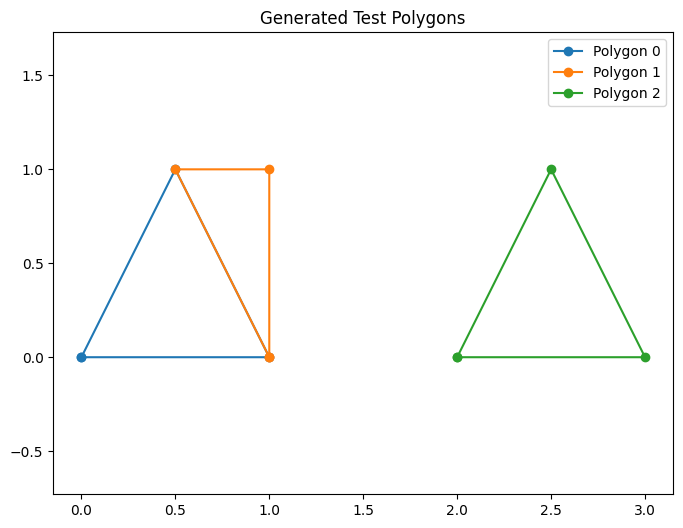

Starting edge extraction from polygons...
Extracting edges from polygon 3/3...
Edge extraction completed. Total edges extracted: 9
Time taken for edge extraction: 0.00 seconds


In [ ]:

# Updated Example Polygons
polygons = [
    np.array([[0, 0], [1, 0], [0.5, 1]]),  # Triangle 1
    np.array([[1, 0], [0.5, 1], [1, 1]]),  # Triangle 2 (shares a vertex with Triangle 1, but not an edge)
    np.array([[2, 0], [3, 0], [2.5, 1]])   # Triangle 3 (shares a vertex with Triangle 2, but not an edge)
]

# Plot Original Polygons
plot_generated_polygons_vertices(polygons)

# Extract edges from polygons
edges, all_points, edge_map, polygon_list = extract_edges_from_polygons(polygons)

connected_polygon_list = connect_polygons(edges, all_points, edge_map, polygon_list)

# Combine Polygons with Shared Edges

combined_polygon_list = combine_polygons(connected_polygon_list)


# Plot Combined Polygons
plot_generated_polygons(combined_polygon_list)


<class 'gdsfactory.component.Component'>
dict_keys([1, 3, 8, 45, 46, 47])
layer:1, polygon number: 23615
layer:3, polygon number: 715274
layer:8, polygon number: 14027
layer:45, polygon number: 57844
layer:46, polygon number: 2
layer:47, polygon number: 32
Processing subset of size 10...
Starting edge extraction from polygons...
Extracting edges from polygon 10/10...
Edge extraction completed. Total edges extracted: 48
Time taken for edge extraction: 0.00 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 0
Time taken for polygon combination: 0.00 seconds
Finished collecting polygon families. Total polygon families found: 10

Finished combining all polygon families.
Time taken for subset size 10: 0.01 seconds
Processing subset of size 20...
Starting edge extraction from polygons...
Extracting edges from polygon 20/20...
Edge extraction complete

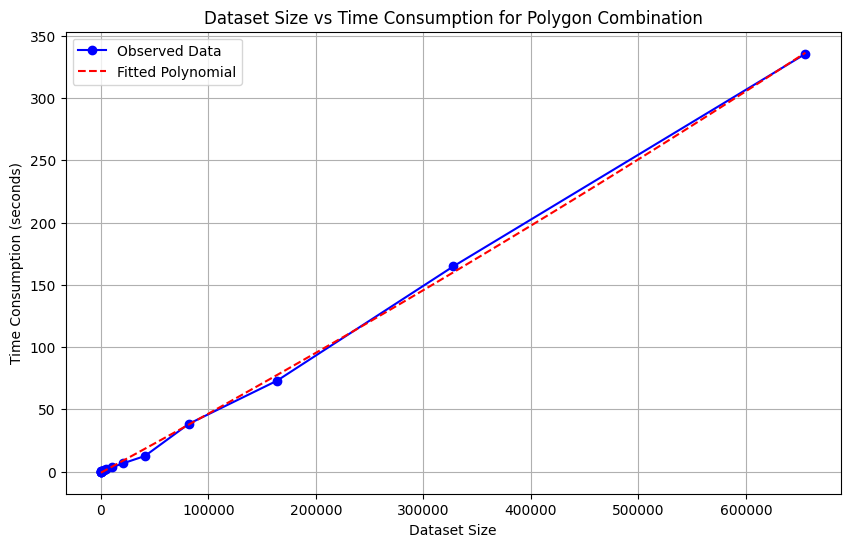

In [15]:
# profiling
import numpy as np
import matplotlib.pyplot as plt
import time
import numpy.polynomial.polynomial as poly

def profile_polygon_combination(polygons):
    """Profile the polygon combination process with varying subset sizes."""
    # Step 1: Create subsets of the data
    subset_sizes = []
    current_size = 10
    while current_size <= len(polygons):
        subset_sizes.append(current_size)
        current_size *= 2
    subset_sizes = [size for size in subset_sizes if size <= len(polygons)]

    # Step 2: Time the function for each subset
    time_results = []
    for size in subset_sizes:
        subset = polygons[:size]
        print(f"Processing subset of size {size}...")
        start_time = time.time()
        # Extract edges and combine polygons
        edges, all_points, edge_map, polygon_list = extract_edges_from_polygons(subset)
        connected_polygon_list = connect_polygons(edges, all_points, polygon_list)
        polygon_family_list = get_polygon_family(connected_polygon_list)
        combined_polygon_list = combine_polygons(polygon_family_list)
        
        # edges, all_points, edge_map = extract_edges_from_polygons(subset)
        # combined_polygons = combine_polygons(edges, all_points, subset)
        elapsed_time = time.time() - start_time
        time_results.append(elapsed_time)
        print(f"Time taken for subset size {size}: {elapsed_time:.2f} seconds")

    # Step 3: Fit a polynomial to the profiling data to predict the time required for larger data sizes
    coefs = poly.Polynomial.fit(subset_sizes, time_results, deg=2).convert().coef

    def predict_time(data_size):
        return coefs[0] + coefs[1] * data_size + coefs[2] * (data_size ** 2)

    # Predict time for a given dataset size (e.g., 1000 polygons)
    predicted_data_size = 1000000
    predicted_time = predict_time(predicted_data_size)
    print(f"Predicted time for dataset size {predicted_data_size}: {predicted_time:.2f} seconds")

    # Step 4: Plot dataset size vs time consumption
    plt.figure(figsize=(10, 6))
    plt.plot(subset_sizes, time_results, marker='o', linestyle='-', color='b', label='Observed Data')

    # Plot the fitted polynomial line
    fitted_line_x = np.linspace(min(subset_sizes), max(subset_sizes), 100)
    fitted_line_y = predict_time(fitted_line_x)
    plt.plot(fitted_line_x, fitted_line_y, linestyle='--', color='r', label='Fitted Polynomial')

    plt.xlabel('Dataset Size')
    plt.ylabel('Time Consumption (seconds)')
    plt.title('Dataset Size vs Time Consumption for Polygon Combination')
    plt.legend()
    plt.grid(True)
    plt.show()

file_path = 'RD0605.01_Exposed.gds'
# file_path = 'RD0605.01_Exposed.gds'
gds = gf.read.import_gds(file_path)
print(type(gds))

gds_polygons = gds.get_polygons_points()
print(gds_polygons.keys())
for k in gds_polygons.keys():
    print(f'layer:{k}, polygon number: {len(gds_polygons[k])}')


test_data = gds_polygons[3]
profile_polygon_combination(test_data)

In [4]:
import gdsfactory as gf
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Point,MultiPoint,LineString,MultiLineString,MultiPolygon
 
file_path = 'RD0605.01_Exposed_EPE.gds'
# file_path = 'RD0605.01_Exposed.gds'
gds = gf.read.import_gds(file_path)
print(type(gds))

gds_polygons = gds.get_polygons_points()
print(gds_polygons.keys())
for k in gds_polygons.keys():
    print(f'layer:{k}, polygon number: {len(gds_polygons[k])}')

<class 'gdsfactory.component.Component'>
dict_keys([3])
layer:3, polygon number: 715274


In [5]:
polygons = gds_polygons[3]
timestr = time.strftime("%Y%m%d-%H-%M-%S")

In [4]:
# before combination
create_gds_from_polygons(polygons, gds_filename=f"not_combined_polygons_{timestr}.gds")

GDS file 'not_combined_polygons_20241204-18-24-25.gds' created successfully with 72415 polygons.


In [6]:
# after combination

# Extract edges from polygons
edges, all_points, edge_map, polygon_list = extract_edges_from_polygons(polygons)

connected_polygon_list = connect_polygons(edges, all_points, polygon_list)


Starting edge extraction from polygons...
Extracting edges from polygon 715274/715274...
Edge extraction completed. Total edges extracted: 3026229
Time taken for edge extraction: 62.56 seconds
Building KD-Tree with edge midpoints...
KD-Tree built successfully.
Detecting shared edges and merging polygons...
Polygon connection discovery completed. Total connected polygons found: 629015
Time taken for polygon combination: 227.85 seconds


In [7]:

# Combine Polygons with Shared Edges
polygon_family_list = get_polygon_family(connected_polygon_list)


Finished collecting polygon families. Total polygon families found: 86266


In [9]:
combined_polygon_list = combine_polygons(polygon_family_list)


Combining polygon families: 81266/86266 completed
Finished combining all polygon families.


In [10]:
combined_polygon_vertices = []
for p in combined_polygon_list:
    # print(type(p))
    vertices = p.get_vertices()
    combined_polygon_vertices.append(vertices)

create_gds_from_polygons(combined_polygon_vertices, gds_filename=f"combined_polygons_{timestr}.gds")

GDS file 'combined_polygons_20241204-18-31-16.gds' created successfully with 86266 polygons.


In [ ]:
import numpy as np

def read_vertices(file_path):
    with open(file_path, 'r') as file:
        # Read the entire file content
        content = file.read()

    # Split the content into different polygons based on blank lines
    polygon_blocks = content.strip().split('\n\n')

    polygons = []
    for block in polygon_blocks:
        # Split each block into lines, then split each line into x and y coordinates
        lines = block.split('\n')
        vertices = [list(map(float, line.split())) for line in lines]
        polygons.append(np.array(vertices))
    
    return polygons

# Usage
file_path = 'test_data.txt'  # Update the file path if necessary
polygons = read_vertices(file_path)

# Print each polygon's vertices to verify
for i, polygon in enumerate(polygons):
    print(f"Polygon {i+1}:\n{polygon}\n")

Polygon 1:
[[-10000.     -4717.662]
 [-10000.     -4717.584]
 [ -8200.     -2917.584]
 [ -8200.     -2917.662]]

Polygon 2:
[[-11275.121  -5992.783]
 [-11275.124  -5992.78 ]
 [-11275.068  -5992.652]
 [-10000.     -4717.584]
 [-10000.     -4717.662]]



In [ ]:
print(combined)

[array([[-11275.068,  -5992.652],
       [-11275.124,  -5992.78 ],
       [-11275.121,  -5992.783],
       [-10000.   ,  -4717.662],
       [ -8200.   ,  -2917.662],
       [ -8200.   ,  -2917.584],
       [-10000.   ,  -4717.584],
       [-11275.068,  -5992.652]])]
